# Using a Conditional Variational AutoEncoder for Image Manipulation

In [1]:
# Importing required modules
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.utils.data as data_utils

import torchvision
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading dataset

In [2]:
path = 'Images/img_align_celeba/'

In [3]:
# Attributes dataset
attr_df = pd.read_csv('Images/list_attr_celeba.csv')

In [ ]:
# Read and concatenate Images and attributes data 
faces =[]
attr = []
for i in range(10000):
    img_id = attr_df.iloc[i,0]
    pic = Image.open(path+img_id)
    pic = pic.resize((64,64))
    pic = np.array(pic.getdata()).reshape(64,64,3)
    pic = pic/255.
    pic = np.moveaxis(pic, -1,0)
    faces.append(pic)
    attr.append(attr_df.iloc[i,1:])
    

In [5]:
image_data = np.array(faces, dtype='float32')
image_attr = np.array(attr, dtype='float32')

In [6]:
image_data = torch.from_numpy(image_data)
image_attr = torch.from_numpy(image_attr)

In [7]:
img_tr_data = data_utils.TensorDataset(image_data, image_attr)

In [8]:
# Making a DataLoader from train data
train_loader = DataLoader(img_tr_data, batch_size=32, shuffle=True)

In [9]:
# Fetching the step size
num_train_steps = len(train_loader.dataset)//120

In [10]:
# QC - Number of batches
num_train_steps

83

# Task1: Develop and train a CVAE to encode and manipulate images in CelebA database

## Creating a model

In [11]:
# Created a CVAE model
class CVAE_arch(nn.Module):
    def __init__(self):
        super(CVAE_arch,self).__init__()
        # FC layer for getting attributes from 40 to 64x64
        self.fc_pre = nn.Linear(40, 64*64)
        # Encoder layers
        self.conv1 = nn.Conv2d(4, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, stride=2, padding=1)
        self.fc_mu = nn.Linear(2048, 128)
        self.fc_logvar = nn.Linear(2048, 128)
        # Decoder layers
        self.fc = nn.Linear(128+40, 512*2*2)
        self.convT1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)
        self.convT2 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
        self.convT3 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.convT4 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.convT5 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)
        self.convT6 = nn.Conv2d(32, 3, 3, stride=1, padding=1)
        
    def encoder(self,x,a):
        a = self.fc_pre(a)
        a = torch.reshape(a, (-1,1,64,64))
        # Concatenating generated attribute data to img data
        x = torch.cat([x,a], dim=1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = F.leaky_relu(self.conv5(x), 0.2)
        x = x.view(-1, 512*2*2)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def decoder(self,z,c):
        zc = torch.cat((z, c), dim=1)
        x = F.leaky_relu(self.fc(zc), 0.2)
        x = x.view(-1, 512, 2, 2)
        x = F.leaky_relu(self.convT1(x), 0.2)
        x = F.leaky_relu(self.convT2(x), 0.2)
        x = F.leaky_relu(self.convT3(x), 0.2)
        x = F.leaky_relu(self.convT4(x), 0.2)
        x = F.leaky_relu(self.convT5(x), 0.2)
        x = torch.tanh(self.convT6(x))
        return x
    
    def forward(self, x, a):        
        mu,var = self.encoder(x,a)
        std = torch.exp(var)
        eps = torch.randn_like(std)
        z = mu+ std*eps
        x = self.decoder(z, a)
        return x, mu, var

In [12]:
# Creating a mse loss function and KLD
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [13]:
# Initializing model and optimizer
model_cvae = CVAE_arch()
model_cvae.to(device)
optimizer = torch.optim.Adam(model_cvae.parameters(), lr= 0.0001)

In [14]:
# Training model
avg_loss = []
for epoch in range(100):
    model_cvae.train()
    trainLoss = 0
    for (img, att) in train_loader:
        img = img.to(device)
        att = att.to(device)
        optimizer.zero_grad()
        recon_x, mu, var = model_cvae(img, att)
        loss = loss_function(recon_x, img, mu, var)
        loss.backward()
        optimizer.step()
        trainLoss+=loss
    # Appending losses
    avgTrainLoss = trainLoss/num_train_steps
    avg_loss.append(avgTrainLoss.cpu().detach().numpy())

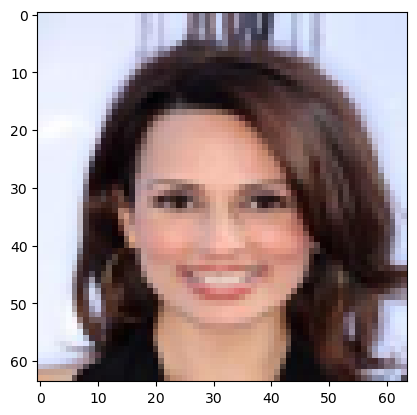

In [15]:
# Original Image
temp = img[11].cpu().detach()
plt.imshow(temp.permute(1,2,0))

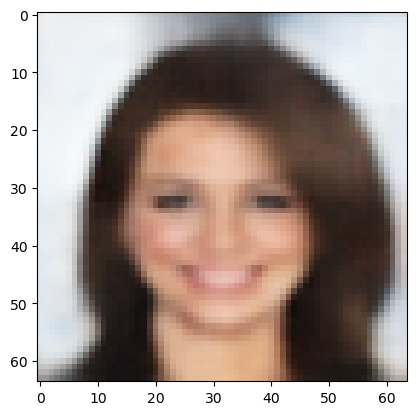

In [16]:
# Image from decoder
temp2 = recon_x[11].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

### Observation

-> Was able to encode and decode the images using the parametrized 'z'

-> Able to replicate most of the features of the image

# Task-2: Manipulating an image by changing the attribute vector input to the encoded image

In [58]:
# Fetching 10 test images for manipulating attributes
test_faces =[]
test_attr = []

for i in range(10):
    img_id = attr_df.iloc[10020+i,0]
    pic = Image.open(path+img_id)
    pic = pic.resize((64,64))
    pic = np.array(pic.getdata()).reshape(64,64,3)
    pic = pic/255.
    pic = np.moveaxis(pic, -1,0)
    test_faces.append(pic)
    test_attr.append(attr_df.iloc[10020+i,1:])    

In [59]:
te_image_data = np.array(test_faces, dtype='float32')
te_image_attr = np.array(test_attr, dtype='float32')

In [60]:
te_image_data = torch.from_numpy(te_image_data)
te_image_attr = torch.from_numpy(te_image_attr)

In [61]:
img_te_data = data_utils.TensorDataset(te_image_data, te_image_attr)

In [62]:
# Making a DataLoader from test data
test_loader = DataLoader(img_te_data, batch_size=10, shuffle=False)

In [63]:
# Generating an encoded image

with torch.no_grad():
    model_cvae.eval()
    
    mean_vecs = []
    var_vecs = []
    
    for (img, att) in test_loader:
        img = img.to(device)
        att = att.to(device)
        mu, var = model_cvae.encoder(img, att)
        
        var_vecs.append(var.cpu().detach().numpy())
        mean_vecs.append(mu.cpu().detach().numpy())

In [64]:
var_vecs = np.array(var_vecs)
var_vecs = torch.from_numpy(var_vecs)

In [65]:
mean_vecs = np.array(mean_vecs)
mean_vecs = torch.from_numpy(mean_vecs)

In [66]:
# Reparametrization trick to fetch z values 
std = torch.exp(var_vecs)
eps = torch.randn_like(std)
z = mean_vecs+ std*eps

In [67]:
# Creating a dummy attribute set with only smiling attribute 
smiling_att = torch.ones([10,40])*-1
smiling_att[:,32] =1

In [68]:
# Creating a dummy attribute set with only mustache attribute 
mustach_att = torch.ones([10,40])*-1
mustach_att[:,23] =1

In [69]:
# Creating a dummy attribute set with only glasses attribute 
glass_att = torch.ones([10,40])*-1
glass_att[:,16] =1

In [70]:
z.shape

torch.Size([1, 10, 128])

In [71]:
# Decoding for smile attribute
smile_decode = model_cvae.decoder(z[0].to(device), smiling_att.to(device))

In [72]:
# Decoding for mustache attribute
mustach_decode = model_cvae.decoder(z[0].to(device), mustach_att.to(device))

In [73]:
# Decoding for glasses attribute
glass_decode = model_cvae.decoder(z[0].to(device), glass_att.to(device))

In [74]:
# QC- smile images 
smile_decode.shape

torch.Size([10, 3, 64, 64])

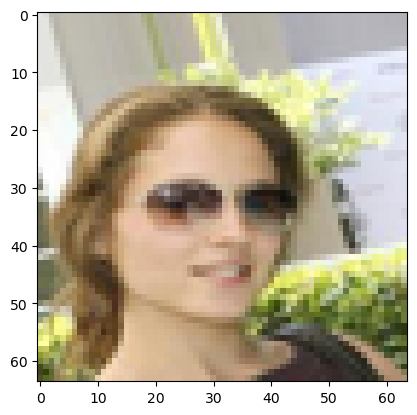

In [91]:
# QC- Original image
im, _  = test_loader.dataset[8]
temp2 = im.cpu().detach()
plt.imshow(temp2.permute(1,2,0))

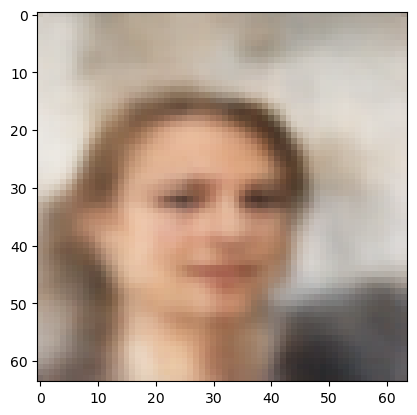

In [92]:
#QC- Smile attribute
temp2 = smile_decode[8].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

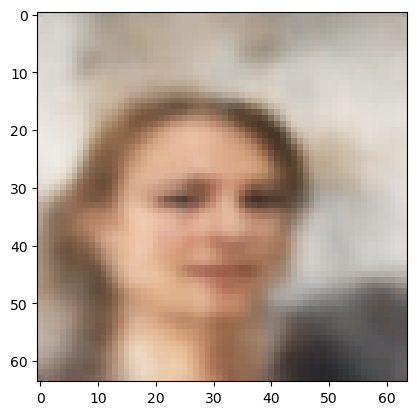

In [93]:
#QC- Mustache attribute
temp2 = mustach_decode[8].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

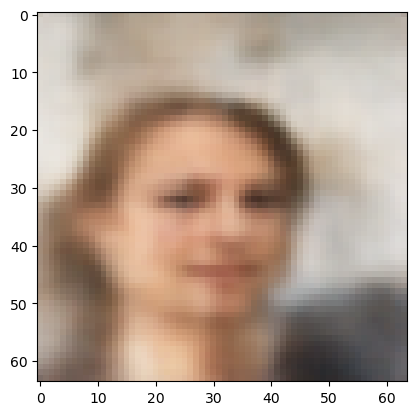

In [94]:
#QC- Glasses attribute
temp2 = glass_decode[8].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

### Observation:

-> Unable to change the attributes based on the preset attributes

-> Few of the images with glasses are decoded without glasses but unable to fetch other attributes on the same image

-> Only one attribute combination changes at the same time on a single image, should optimize or change parameters to fetch better decoded data.

# Task-3: Morph one image to another

In [38]:
# Fetch Images for tesing and creating latent vectors
mu_img_A = torch.reshape(mean_vecs[0,1], (1,128))
mu_img_B = torch.reshape(mean_vecs[0,2], (1,128))
att_B = torch.reshape(test_loader.dataset[2][1], (1,40))

In [39]:
# Get a random attribute vector
c_in = torch.randn_like(att_B)

In [40]:
# Create a random z vectors
z_in_1 = torch.randn_like(mu_img_A)
z_in_2 = torch.randn_like(mu_img_A)

In [41]:
# Updating delta values progressively from 0 to 1
delta = 1./5
img_a_b = []
for i in range(6):
    delt = delta*i
    v = (1.0-delt)*z_in_1 + delt*z_in_2
    decode_out = model_cvae.decoder(v.to(device), c_in.to(device))
    img_a_b.append(decode_out)

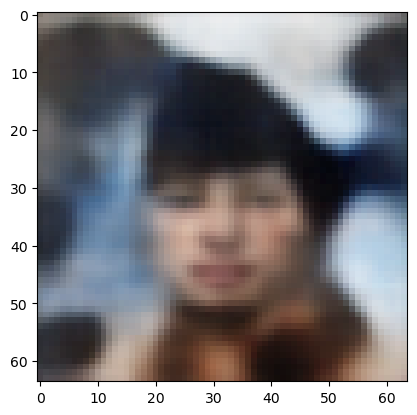

In [43]:
# First image- Followed y images slowly morphed from one image to another
temp2 = img_a_b[0][0].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

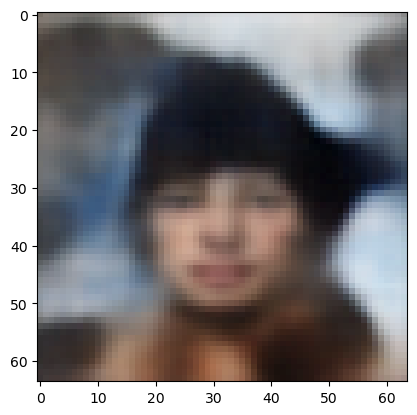

In [45]:
temp2 = img_a_b[1][0].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


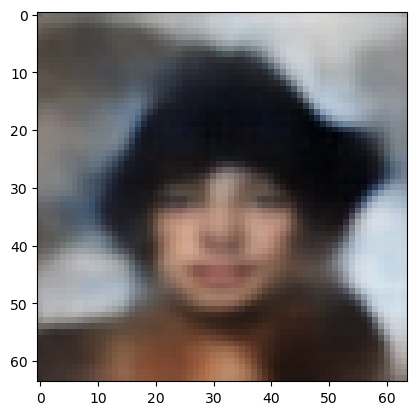

In [46]:
temp2 = img_a_b[2][0].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

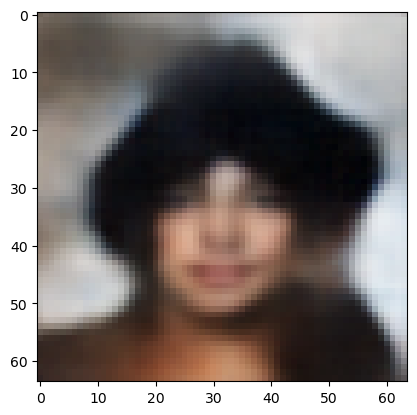

In [47]:
temp2 = img_a_b[3][0].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


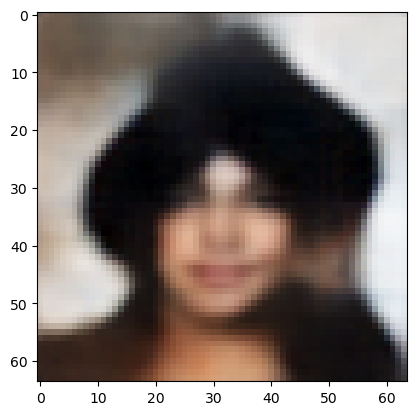

In [48]:
temp2 = img_a_b[4][0].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


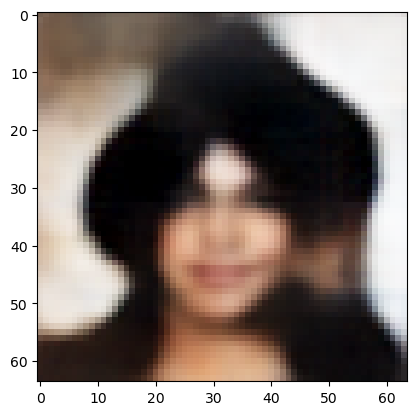

In [44]:
# Final image
temp2 = img_a_b[5][0].cpu().detach()
plt.imshow(temp2.permute(1,2,0))

### Observation:

-> Was able to slowly morph from one image to another image using a delta factor of 1/5.

# End